# EE428 Assignment 1-2: K-Nearest Neighbors (k-NN)

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Julie DICKERSON, #12345678

**Your Answer:**   
Jack Krause, #855245432

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

Manual reloading will use importlib
then each time we want to reload a python script we need:
import mymodule
importlib.invalidate_caches()
importlib.reload(mymodule)

In [23]:
# This is no longer working correctly
#%load_ext autoreload
#%autoreload 2
# Set up for manual reloading instead
import importlib


### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
The following cell should print the filenames from the assignment:

```
['pytorch101.py', 'knn.py', 'knn.ipynb', 'EE428', 'pytorch101.ipynb']
```

In [25]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2024S folder and put all the files under A1 folder, then '2024S/A1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'F2025/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab_EE428/Colab_F2025/A1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['knn.py', 'EE428', '__pycache__', 'pytorch101.ipynb', 'pytorch101.py', 'knn2025.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from knn.py!
```

as well as the last edit time for the file `knn.py`.

In [26]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

import torch
from typing import Dict, List


knn_path = os.path.join(GOOGLE_DRIVE_PATH, 'knn.py')
knn_edit_time = time.ctime(os.path.getmtime(knn_path))
print('knn.py last edited on %s' % knn_edit_time)

knn.py last edited on Wed Sep  3 15:31:40 2025


# Data preprocessing / Visualization

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [27]:
import EE428
from   EE428 import data
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Load the CIFAR-10 dataset
The utility function `EE428.data.cifar10()` returns the entire CIFAR-10 dataset as a set of four **Torch tensors**:

- `x_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `x_test` contains all test images
- `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [28]:
x_train, y_train, x_test, y_test = EE428.data.cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


## Visualize the dataset
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

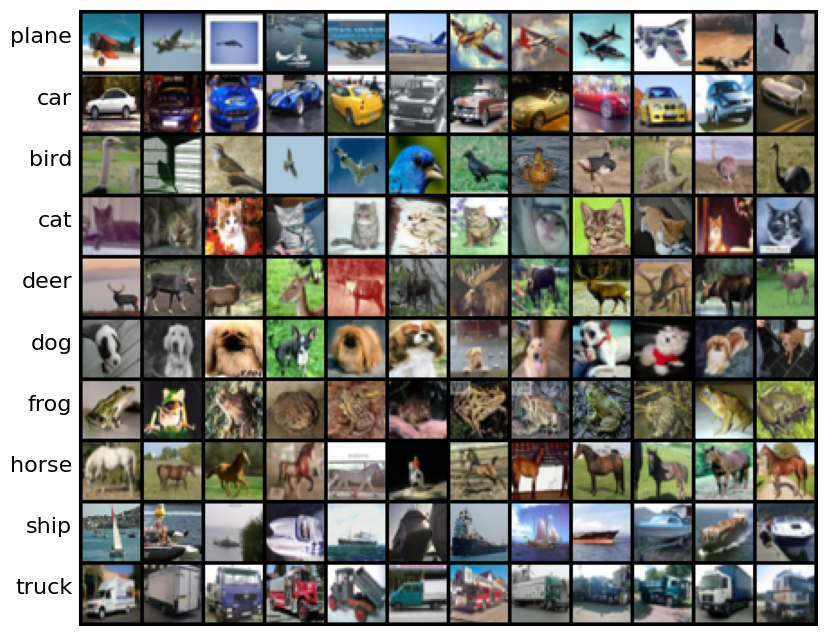

In [29]:
import random
from  torchvision.utils import make_grid
from  EE428 import utils

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(EE428.utils.tensor_to_image(img))
plt.axis('off')
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

The function `EE428.data.cifar10()` can automatically subsample the CIFAR10 dataset for us. To see how to use it, we can check the documentation using the built-in `help` command:

In [30]:
help(EE428.data.cifar10)

Help on function cifar10 in module EE428.data:

cifar10(num_train=None, num_test=None, x_dtype=torch.float32)
    Return the CIFAR10 dataset, automatically downloading it if necessary.
    This function can also subsample the dataset.

    Inputs:
    - num_train: [Optional] How many samples to keep from the training set.
      If not provided, then keep the entire training set.
    - num_test: [Optional] How many samples to keep from the test set.
      If not provided, then keep the entire test set.
    - x_dtype: [Optional] Data type of the input image

    Returns:
    - x_train: `x_dtype` tensor of shape (num_train, 3, 32, 32)
    - y_train: int64 tensor of shape (num_train, 3, 32, 32)
    - x_test: `x_dtype` tensor of shape (num_test, 3, 32, 32)
    - y_test: int64 tensor of shape (num_test, 3, 32, 32)



We will subsample the data to use only 500 training examples and 250 test examples:

In [13]:
num_train = 500
num_test = 250

x_train, y_train, x_test, y_test = EE428.data.cifar10(num_train, num_test)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([500, 3, 32, 32])
  labels shape:  torch.Size([500])
Test set:
  data shape:  torch.Size([250, 3, 32, 32])
  labels shape torch.Size([250])


##Question 1 Data Preprocessing

For pixel values $𝑝^{(k)}_{𝑖𝑗}$ at location $(𝑖,𝑗)$ of some image $I_k$ , the mean 𝜇 across all pixels over all images is

$𝜇=\frac{1}{𝑛ℎ𝑤} \sum_{k=1}^{n} \sum_{h=1}^{n}\sum_{w=1}^{n}𝑝^{(k)}_{𝑖𝑗}$

And the pixel-wise mean $\mu_{ij}$ across all images is $𝜇=\frac{1}{𝑛} \sum_{k=1}^{n} 𝑝^{(k)}_{𝑖𝑗}$.

The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ are defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1.   Subtracting the overall mean $\mu$ from all pixel values.
2.   Subtracting the per pixel mean $\mu_{ij}$ from all the pixels in each location.
3.   Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4.   Subtracting the per pixel mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5.  Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

*Your Answer:*

*Your Explanation:*

# K-Nearest Neighbors (k-NN)

## Compute distances: Naive implementation
Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Compute the (squared Euclidean) distances between all training examples and all test examples
2. Given these distances, for each test example find its k nearest neighbors and have them vote for the label to output

Lets begin with computing the distance matrix between all training and test examples. First we will implement a naive version of the distance computation, using explicit loops over the training and test sets. Implement the function `compute_distances_two_loops` below.

**NOTE: When implementing distance functions for this assignment, you may not use functions `torch.norm` or `torch.dist` (or their instance method variants `x.norm` / `x.dist`); you may not use any functions from `torch.nn` or `torch.nn.functional`.**

In [ ]:

 def compute_distances_two_loops(x_train: torch.Tensor, x_test: torch.Tensor):
    """
    Computes the squared Euclidean distance between each element of training
    set and each element of test set. Images should be flattened and treated
    as vectors.

    Args:
        x_train: Tensor of shape (num_train, D1, D2, ...)
        x_test: Tensor of shape (num_test, D1, D2, ...)

    Returns:
        dists: Tensor of shape (num_train, num_test) where dists[i, j]
            is the squared Euclidean distance between the i-th training point
            and the j-th test point. It should have the same dtype as x_train.
    """
    # Initialize dists to be a tensor of shape (num_train, num_test) with the
    # same datatype and device as x_train
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    ##########################################################################
    # TODO: Implement this function using a pair of nested loops over the    #
    # training data and the test data.                                       #
    #                                                                        #
    # You may not use torch.norm (or its instance method variant), nor any   #
    # functions from torch.nn or torch.nn.functional.                        #
    ##########################################################################
    # Replace "pass" statement with your code
    pass
    ##########################################################################
    #                           END OF YOUR CODE                             #
    ##########################################################################
    return dists


In [14]:

torch.manual_seed(0)
num_train = 500
num_test = 250
x_train, y_train, x_test, y_test = EE428.data.cifar10(num_train, num_test)

dists = compute_distances_two_loops(x_train, x_test)
print('dists has shape: ', dists.shape)

dists has shape:  torch.Size([500, 250])


As a visual debugging step, we can visualize the distance matrix, where each row is a test example and each column is a training example.

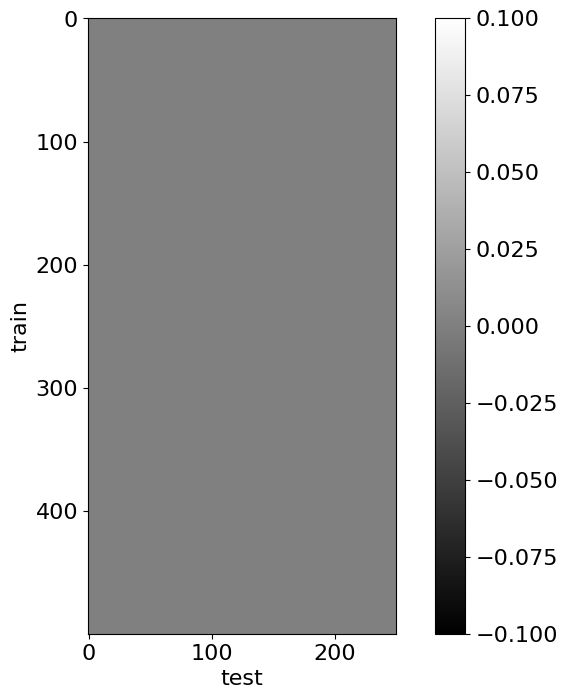

In [15]:
plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

##Question 2

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

    What in the data is the cause behind the distinctly bright rows?
    What causes the columns?

Y𝑜𝑢𝑟𝐴𝑛𝑠𝑤𝑒𝑟:
fill this in.

## Compute distances: Vectorization
Our implementation of the distance computation above is fairly inefficient since it uses nested Python loops over the training and test sets.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

The process of eliminating explict loops from your code is called **vectorization**. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our distance computation function.

As a first step toward vectorizing our distance computation, you will implement a version that uses only a single Python loop over the training data. In the file `knn.py`, complete the implementation of the function `compute_distances_one_loop`.

We can check the correctness of our one-loop implementation by comparing it with our two-loop implementation on some randomly generated data.

Note that we do the comparison with 64-bit floating points for increased numeric precision.

In [ ]:
def compute_distances_one_loop(x_train: torch.Tensor, x_test: torch.Tensor):
    """
    Computes the squared Euclidean distance between each element of training
    set and each element of test set. Images should be flattened and treated
    as vectors.

    This implementation uses only a single loop over the training data.

       Args:
        x_train: Tensor of shape (num_train, D1, D2, ...)
        x_test: Tensor of shape (num_test, D1, D2, ...)

    Returns:
        dists: Tensor of shape (num_train, num_test) where dists[i, j]
            is the squared Euclidean distance between the i-th training point
            and the j-th test point. It should have the same dtype as x_train.
    """
    # Initialize dists to be a tensor of shape (num_train, num_test) with the
    # same datatype and device as x_train
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    ##########################################################################
    # TODO: Implement this function using only a single loop over x_train.   #
    #                                                                        #
    # You may not use torch.norm (or its instance method variant), nor any   #
    # functions from torch.nn or torch.nn.functional.                        #
    ##########################################################################
    # Replace "pass" statement with your code
    pass
    ##########################################################################
    #                           END OF YOUR CODE                             #
    ##########################################################################
    return dists

In [20]:

torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
difference = (dists_one - dists_two).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
    print('Good! The distance matrices match')
else:
    print('Uh-oh! The distance matrices are different')

Difference:  0.0
Good! The distance matrices match


You will now implement a fully vectorized version of the distance computation function
that does not use any Python loops. Implement the function `compute_distances_no_loops` below.

As before, we can check the correctness of our implementation by comparing the fully vectorized version against the original naive version:

In [ ]:
def compute_distances_no_loops(x_train: torch.Tensor, x_test: torch.Tensor):
    """
    Computes the squared Euclidean distance between each element of training
    set and each element of test set. Images should be flattened and treated
    as vectors.

    This implementation should not use any Python loops. For memory-efficiency,
    it also should not create any large intermediate tensors; in particular you
    should not create any intermediate tensors with O(num_train * num_test)
    elements.

    Args:
        x_train: Tensor of shape (num_train, C, H, W)
        x_test: Tensor of shape (num_test, C, H, W)

    Returns:
        dists: Tensor of shape (num_train, num_test) where dists[i, j] is
            the squared Euclidean distance between the i-th training point and
            the j-th test point.
    """
    # Initialize dists to be a tensor of shape (num_train, num_test) with the
    # same datatype and device as x_train
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    ##########################################################################
    # TODO: Implement this function without using any explicit loops and     #
    # without creating any intermediate tensors with O(num_train * num_test) #
    # elements.                                                              #
    #                                                                        #
    # You may not use torch.norm (or its instance method variant), nor any   #
    # functions from torch.nn or torch.nn.functional.                        #
    #                                                                        #
    # HINT: Try to formulate the Euclidean distance using two broadcast sums #
    #       and a matrix multiply.                                           #
    ##########################################################################
    # Replace "pass" statement with your code
    pass
    ##########################################################################
    #                           END OF YOUR CODE                             #
    ##########################################################################
    return dists

In [21]:

torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)
difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

Difference:  0.0
Good! The distance matrices match


We can now compare the speed of our three implementations. If you've implemented everything properly, the one-loop implementation should take less than 4 seconds to run, and the fully vectorized implementation should take less than 0.1 seconds to run.

In [22]:
import time

def timeit(f, *args):
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print('Two loop version took %.2f seconds' % two_loop_time)

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print('One loop version took %.2f seconds (%.1fX speedup)'
      % (one_loop_time, speedup))

no_loop_time = timeit(compute_distances_no_loops, x_train_rand, x_test_rand)
speedup = two_loop_time / no_loop_time
print('No loop version took %.2f seconds (%.1fX speedup)'
      % (no_loop_time, speedup))

Two loop version took 0.00 seconds
One loop version took 0.00 seconds (0.1X speedup)
No loop version took 0.00 seconds (1.2X speedup)


## Predict labels
Now that we have a method for computing distances between training and test examples, we need to implement a function that uses those distances together with the training labels to predict labels for test samples.

Implement the function `predict_labels` below.

In [ ]:

    def predict(self, x_test: torch.Tensor, k: int = 1):
        """
        Make predictions using the classifier.

        Args:
            x_test: Tensor of shape (num_test, C, H, W) giving test samples.
            k: The number of neighbors to use for predictions.

        Returns:
            y_test_pred: Tensor of shape (num_test,) giving predicted labels
                for the test samples.
        """
        y_test_pred = None
        ######################################################################
        # TODO: Implement this method. You should use the functions you      #
        # wrote above for computing distances (use the no-loop variant) and  #
        # to predict output labels.                                          #
        ######################################################################
        # Replace "pass" statement with your code
        pass
        ######################################################################
        #                         END OF YOUR CODE                           #
        ######################################################################
        return y_test_pred

In [ ]:


torch.manual_seed(0)
dists = torch.tensor([
    [0.3, 0.4, 0.1],
    [0.1, 0.5, 0.5],
    [0.4, 0.1, 0.2],
    [0.2, 0.2, 0.4],
    [0.5, 0.3, 0.3],
])
y_train = torch.tensor([0, 1, 0, 1, 2])
y_pred_expected = torch.tensor([1, 0, 0])
y_pred = predict_labels(dists, y_train, k=3)
correct = y_pred.tolist() == y_pred_expected.tolist()
print('Correct: ', correct)

Now we have implemented all the required functionality for the K-Nearest Neighbor classifier. In the file `knn.py`, complete the implementation of the `KnnClassifer` class.

We can get some intuition into the KNN classifier by visualizing its predictions on toy 2D data. Here we will generate some random training and test points in 2D, and assign random labels to the training points. We can then make predictions for the test points, and visualize both training and test points. Training points are shown as stars, and tet points are shown as small transparent circles. The color of each point denots its label -- ground-truth label for training points, and predicted label for test points.

In [ ]:

    def check_accuracy(
        self,
        x_test: torch.Tensor,
        y_test: torch.Tensor,
        k: int = 1,
        quiet: bool = False
    ):
        """
        Utility method for checking the accuracy of this classifier on test
        data. Returns the accuracy of the classifier on the test data, and
        also prints a message giving the accuracy.

        Args:
            x_test: Tensor of shape (num_test, C, H, W) giving test samples.
            y_test: int64 Tensor of shape (num_test,) giving test labels.
            k: The number of neighbors to use for prediction.
            quiet: If True, don't print a message.

        Returns:
            accuracy: Accuracy of this classifier on the test data, as a
                percent. Python float in the range [0, 100]
        """
        y_test_pred = self.predict(x_test, k=k)
        num_samples = x_test.shape[0]
        num_correct = (y_test == y_test_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        msg = (
            f"Got {num_correct} / {num_samples} correct; "
            f"accuracy is {accuracy:.2f}%"
        )
        if not quiet:
            print(msg)
        return accuracy


In [ ]:
class KnnClassifier:

    def __init__(self, x_train: torch.Tensor, y_train: torch.Tensor):
        """
        Create a new K-Nearest Neighbor classifier with the specified training
        data. In the initializer we simply memorize the provided training data.

        Args:
            x_train: Tensor of shape (num_train, C, H, W) giving training data
            y_train: int64 Tensor of shape (num_train, ) giving training labels
        """
        ######################################################################
        # TODO: Implement the initializer for this class. It should perform  #
        # no computation and simply memorize the training data in            #
        # `self.x_train` and `self.y_train`, accordingly.                    #
        ######################################################################
        # Replace "pass" statement with your code
        pass
        ######################################################################
        #                         END OF YOUR CODE                           #
        ######################################################################


In [ ]:

num_test = 10000
num_train = 20
num_classes = 5

# Generate random training and test data
torch.manual_seed(128)
x_train = torch.rand(num_train, 2)
y_train = torch.randint(num_classes, size=(num_train,))
x_test = torch.rand(num_test, 2)
classifier = KnnClassifier(x_train, y_train)

# Plot predictions for different values of k
for k in [1, 3, 5]:
    y_test = classifier.predict(x_test, k=k)
    plt.gcf().set_size_inches(8, 8)
    class_colors = ['r', 'g', 'b', 'k', 'y']
    train_colors = [class_colors[c] for c in y_train]
    test_colors = [class_colors[c] for c in y_test]
    plt.scatter(x_test[:, 0], x_test[:, 1],
                color=test_colors, marker='o', s=32, alpha=0.05)
    plt.scatter(x_train[:, 0], x_train[:, 1],
                color=train_colors, marker='*', s=128.0)
    plt.title('Predictions for k = %d' % k, size=16)
    plt.show()

We can use the exact same KNN code to perform image classification on CIFAR-10!

Now lets put everything together and test our K-NN clasifier on a subset of CIFAR-10, using k=1:

If you've implemented everything correctly you should see an accuracy of about 27%.

In [ ]:
torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = EE428.data.cifar10(num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Now lets increase to k=5. You should see a slightly higher accuracy than k=1:

In [ ]:
torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = EE428.data.cifar10(num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=5)

You can then use cross validation or experimentation to choose a good value for K.

You should get an accuracy above 28%.

##Question 3

Which of the following statements about 𝑘-Nearest Neighbor (𝑘-NN) are true or false or neither in a classification setting, and for all 𝑘

Mark each statement as True or False and give an explanation of your answer.

1.   The decision boundary of the k-NN classifier is linear.
2.   The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3.  The test error of a 1-NN will always be lower than that of a 5-NN.
4.  The time needed to classify a test example with the k-NN classifier grows with the size of the training set.



Y𝑜𝑢𝑟𝐴𝑛𝑠𝑤𝑒𝑟:

Y𝑜𝑢𝑟𝐸𝑥𝑝𝑙𝑎𝑛𝑎𝑡𝑖𝑜𝑛:

## Submit Your Work
After completing both notebooks for this assignment (`pytorch101.ipynb` and this notebook, `knn.ipynb`), run the following cell to create a `.zip` file for you to download and turn in. Be sure that you have run the notebook!

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from EE428.submit import make_a1_submission
uniquename = input("Enter your uniquename (e.g. julied): ")
umid = input("Enter your ISUid (e.g. 12345678): ")

make_a1_submission(GOOGLE_DRIVE_PATH, uniquename, umid)